# Spotify Music Recommendation System

In [2]:
import os
import numpy as np
import pandas as pd
import re 
import json 
import sys
import itertools
from pprint import pprint


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

import warnings
warnings.filterwarnings("ignore")

In [25]:
data_path = 'C:/Users/adity/OneDrive/Documents/GitHub/Spotify-Music-Recommendation/data/processed_data.csv'
data = pd.read_csv(data_path)
data.head(3)


,Unnamed: 0,Unnamed: 0.1,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_x,album_name,...,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop
0,0,0,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
1,1,7734,73,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
2,2,14037,14,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69


In [4]:
client_id = '4379e8dc929f4f3d8b296962fb549d56'
client_secret= '08a15f73be3742f18227aec6fb9e61b4'
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()
        
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='https://mysongrecommender/dashboard/')
sp = spotipy.Spotify(auth=token)

In [9]:
len(data)

67499

[Text(0.5, 0, 'pos'),
 Text(1.5, 0, 'duration_ms_x'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'energy'),
 Text(4.5, 0, 'loudness'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms_y'),
 Text(12.5, 0, 'time_signature'),
 Text(13.5, 0, 'artist_pop'),
 Text(14.5, 0, 'track_pop')]

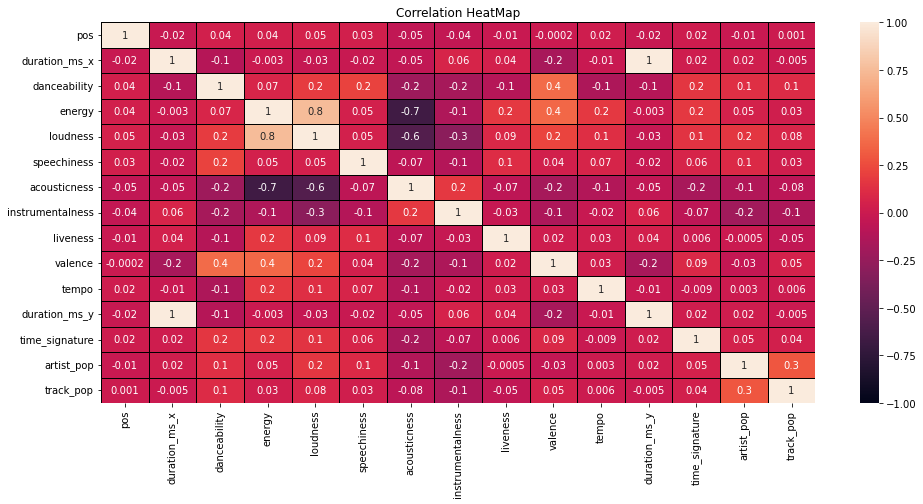

In [10]:
corr_df=data.drop(["key","mode","Unnamed: 0","Unnamed: 0.1"],axis=1).corr(method="pearson")
plt.figure(figsize=(16,7))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g", vmin=-1, vmax=1, center=0, cmap="rocket", linewidths=1, linecolor="Black")
heatmap.set_title("Correlation HeatMap")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

[Text(0.5, 1.0, 'Track Popularity vs Acousticness Correlation')]

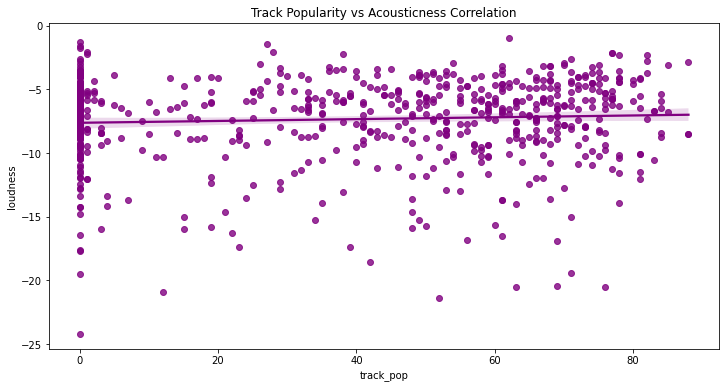

In [16]:
sample_data=data.sample(int(0.01*len(data)))
plt.figure(figsize=(12,6))
sns.regplot(data=sample_data, y="loudness", x="track_pop",color="purple").set(title="Track Popularity vs Acousticness Correlation")

[Text(0.5, 1.0, 'Popularity vs Energy Correlation')]

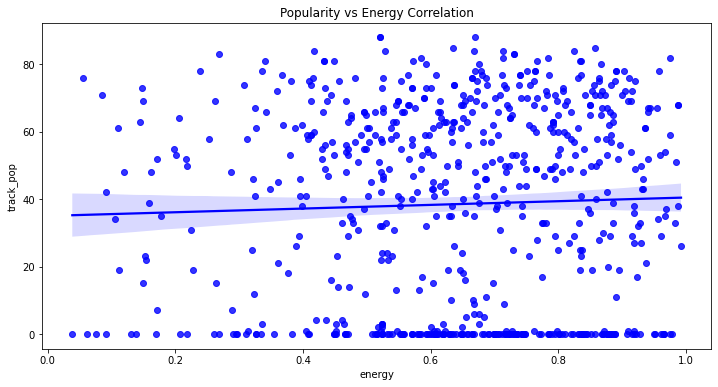

In [23]:
plt.figure(figsize=(12,6))
sns.regplot(data=sample_data, y="track_pop", x="energy",color="blue").set(title="Popularity vs Energy Correlation")

In [17]:
data[['artist_name','track_name','name']]

,artist_name,track_name,name
0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),Throwbacks
1,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),w o r k o u t
2,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),party playlist
3,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),Dance mix
4,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),spin
...,...,...,...
67494,Jon D,I Don't Know,thinking of you
67495,Big Words,The Answer,thinking of you
67496,Allan Rayman,25.22,thinking of you
67497,Jon Jason,Good Feeling,thinking of you


In [18]:
def drop_duplicates(df):
    '''
    Drop duplicate songs
    '''
    df['artists_song'] = df.apply(lambda row: row['artist_name']+row['track_name'],axis = 1)
    return df.drop_duplicates('artists_song')

unique_songs = drop_duplicates(data)
print("Are all songs unique: ",len(pd.unique(unique_songs.artists_song))==len(unique_songs))

Are all songs unique:  True


In [19]:
def select_cols(df):
       '''
       Select useful columns
       '''
       return df[['artist_name','id','track_name','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "artist_pop", "genres", "track_pop"]]
unique_songs = select_cols(unique_songs)
unique_songs.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
6,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83
19,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25
46,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79
55,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2


In [20]:
def genre_preprocess(df):
    '''
    Preprocess the genre data
    '''
    df['genres_list'] = df['genres'].apply(lambda x: x.split(" "))
    return df
unique_songs = genre_preprocess(unique_songs)
unique_songs['genres_list'].head()

0     [dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...
6                       [dance_pop, pop, post-teen_pop]
19                                [dance_pop, pop, r&b]
46                                     [dance_pop, pop]
55                             [pop_rap, reggae_fusion]
Name: genres_list, dtype: object

In [21]:
def playlist_preprocess(df):
    '''
    Preprocess imported playlist
    '''
    df = drop_duplicates(df)
    df = select_cols(df)
    df = genre_preprocess(df)

    return df

In [22]:
!pip install textblob
from textblob import TextBlob

def getSubjectivity(text):
  '''
  Getting the Subjectivity using TextBlob
  '''
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  '''
  Getting the Polarity using TextBlob
  '''
  return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
  '''
  Categorizing the Polarity & Subjectivity score
  '''
  if task == "subjectivity":
    if score < 1/3:
      return "low"
    elif score > 1/3:
      return "high"
    else:
      return "medium"
  else:
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

def sentiment_analysis(df, text_col):
  '''
  Perform sentiment analysis on text
  ---
  Input:
  df (pandas dataframe): Dataframe of interest
  text_col (str): column of interest
  '''
  df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
  df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
  return df

In [27]:
sentiment = sentiment_analysis(unique_songs, "track_name")
sentiment.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"[dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...",low,Neutral
6,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"[dance_pop, pop, post-teen_pop]",low,Neutral
19,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"[dance_pop, pop, r&b]",high,Negative
46,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"[dance_pop, pop]",low,Neutral
55,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"[pop_rap, reggae_fusion]",low,Neutral


In [28]:
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [29]:
subject_ohe = ohe_prep(sentiment, 'subjectivity','subject')
subject_ohe.iloc[0]

subject|high      0
subject|low       1
subject|medium    0
Name: 0, dtype: uint8

In [31]:
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(unique_songs['genres_list'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
genre_df.drop(columns='genre|unknown')
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

genre|21st_century_classical    0.0
genre|432hz                     0.0
genre|_hip_hop                  0.0
genre|_roll                     0.0
genre|a_cappella                0.0
                               ... 
genre|zambian_hip_hop           0.0
genre|zhongguo_feng             0.0
genre|zolo                      0.0
genre|zouk                      0.0
genre|zouk_riddim               0.0
Name: 0, Length: 2147, dtype: float64

In [ ]:
##Clustering Genres with Kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10, init='k-means++'))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [ ]:
from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False, init='k-means++'))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [ ]:
from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()


### Using Spotify API to build recommendation system

In [ ]:
!pip install spotipy

In [ ]:
client_id = '4379e8dc929f4f3d8b296962fb549d56'
client_secret= '08a15f73be3742f18227aec6fb9e61b4'

In [ ]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [ ]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='https://mysongrecommender/dashboard/')
sp = spotipy.Spotify(auth=token)


In [ ]:
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [ ]:
id_name

In [ ]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [ ]:
id_name

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [ ]:
playlist_Heart = create_necessary_outputs('Wilson’s Heart', id_name,tracks_data)
playlist_Heart

In [ ]:
visualize_songs(playlist_Heart)


In [ ]:
def generate_playlist_feature(tracks_data, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [ ]:
complete_feature_set_playlist_vector_heart, complete_feature_set_nonplaylist_heart = generate_playlist_feature(complete_feature_set, playlist_Heart, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)
complete_feature_set_playlist_vector_heart.shape

In [ ]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [ ]:
edm_top40 = generate_playlist_recos(tracks_data, complete_feature_set_playlist_vector_heart, complete_feature_set_nonplaylist_heart)

In [ ]:
edm_top40

In [ ]:
#visualize_songs(edm_top40)

In [ ]:
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [ ]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):
    
    metadata_cols = ['name', 'release_date', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
recommend_songs([{'name': 'Come As You Are', 'release_date':1991},
                {'name': 'Smells Like Teen Spirit', 'release_date': 1991},
                {'name': 'Lithium', 'release_date': 1992},
                {'name': 'All Apologies', 'release_date': 1993},
                {'name': 'Stay Away', 'release_date': 1993}],  tracks_data)